## Background

---

<div class="alert alert-block alert-info">
<b>Stages in Building LLM from scratch</b> 
<p>   

Below are the stages of building LLM from scratch


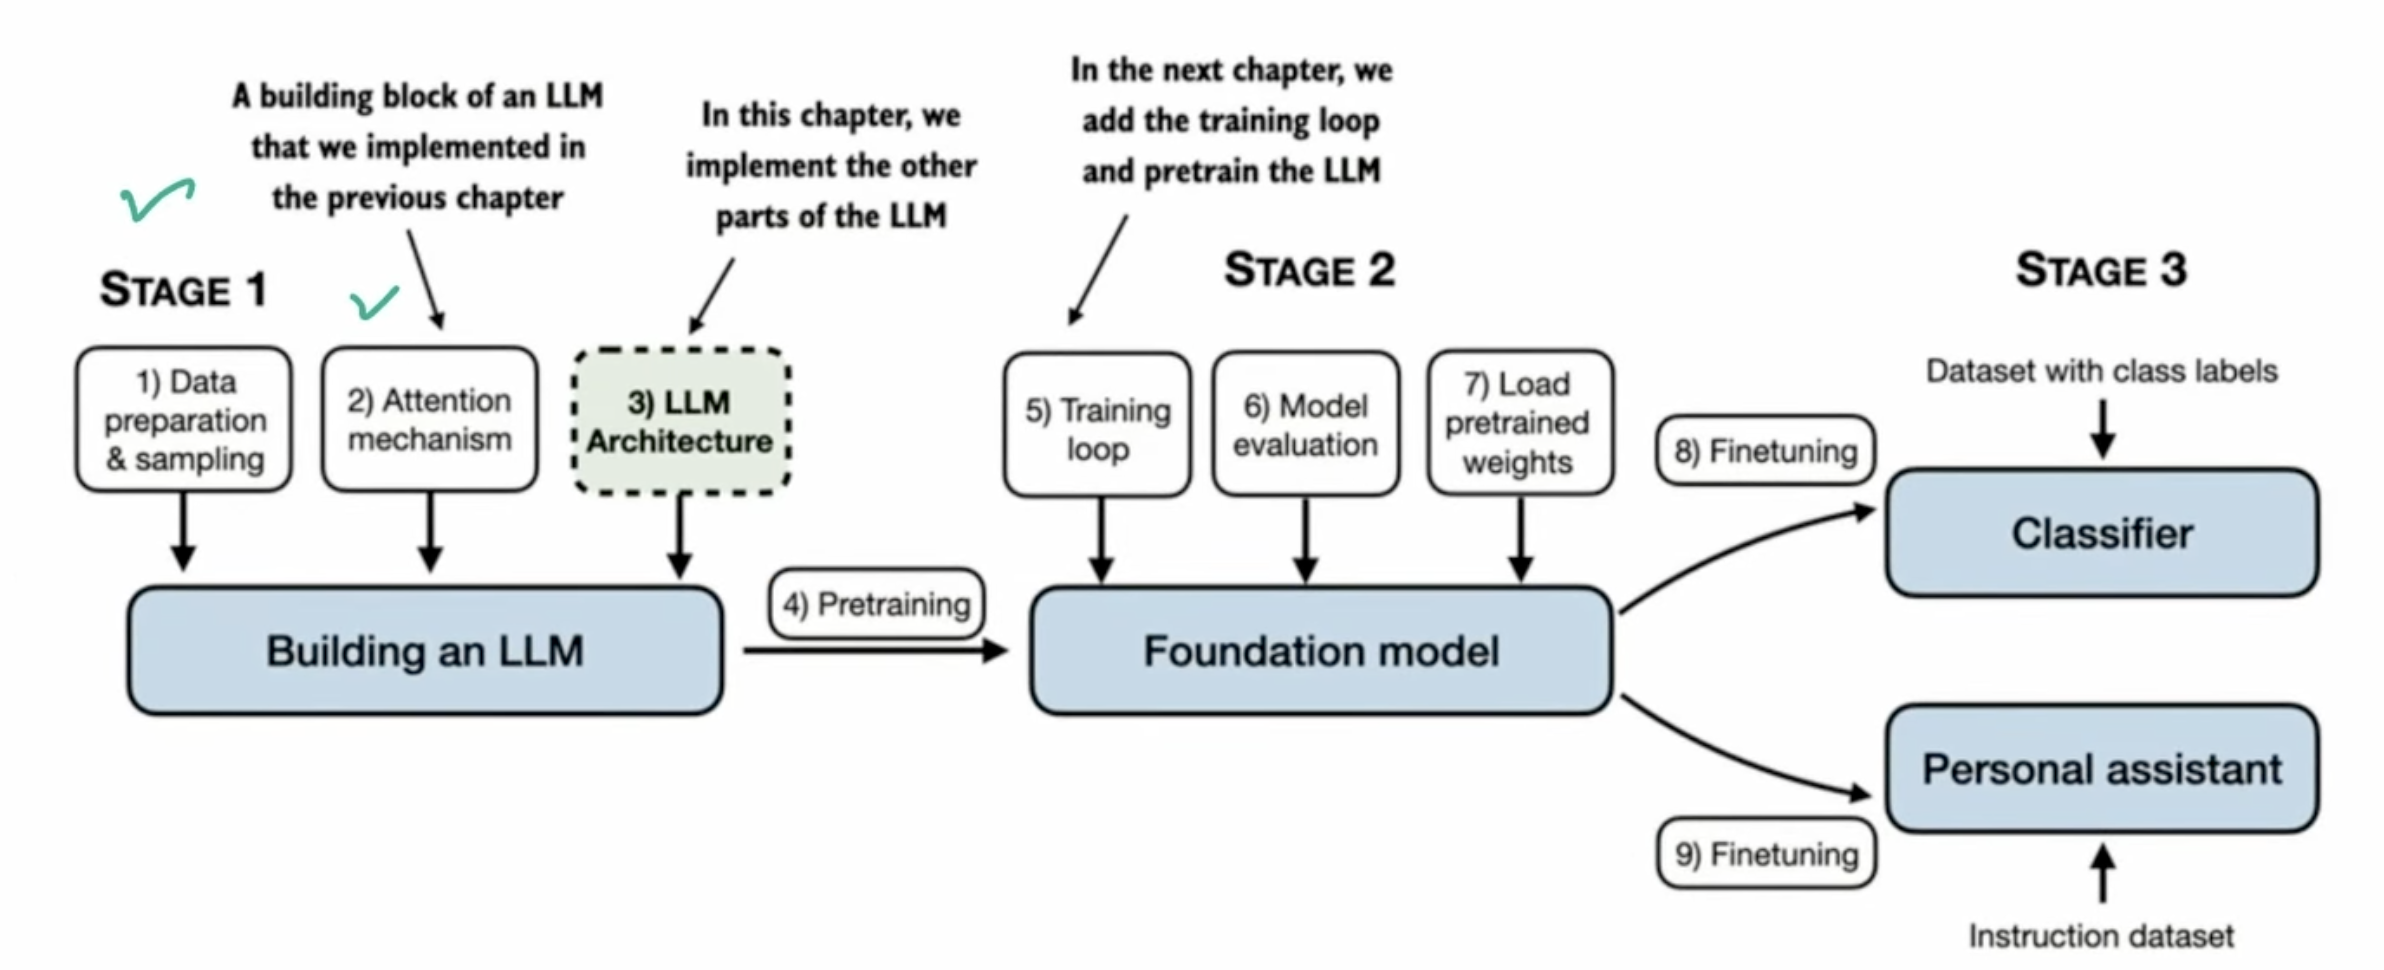



</p>
</div>





<div class="alert alert-block alert-info">
<b>Lets See the flow and building blocks of the LLM</b> 
<p>   

As your see from below the sequence

1. We give input sequence (E.g "Every efforts moves you")
2. Then we <font color=blue> tokenize </font> this input sequence using <font color=blue> Byte-Pair Encoding algorithm </font>
3. This Tokenized input is converted into <font color=blue> Embedded Vector + Positional Embedding Vector </font>
4. This Embedding vectors is then converted using <font color=blue> Context Vectors </font> with the help of <font color=blue> Masked multi-head Attention </font>
5. These Context Vector are <font color=blue> enriched vector </font> that contains semantic and details of how the token is related to other tokens in input sequence walong with the Weightable
6. Next comes the <font color=blue> Transformer Block </font> . This is the most important part of LLm architecture
7. The <font color=blue> output from transformer </font> is then decoded to predict the next word
   

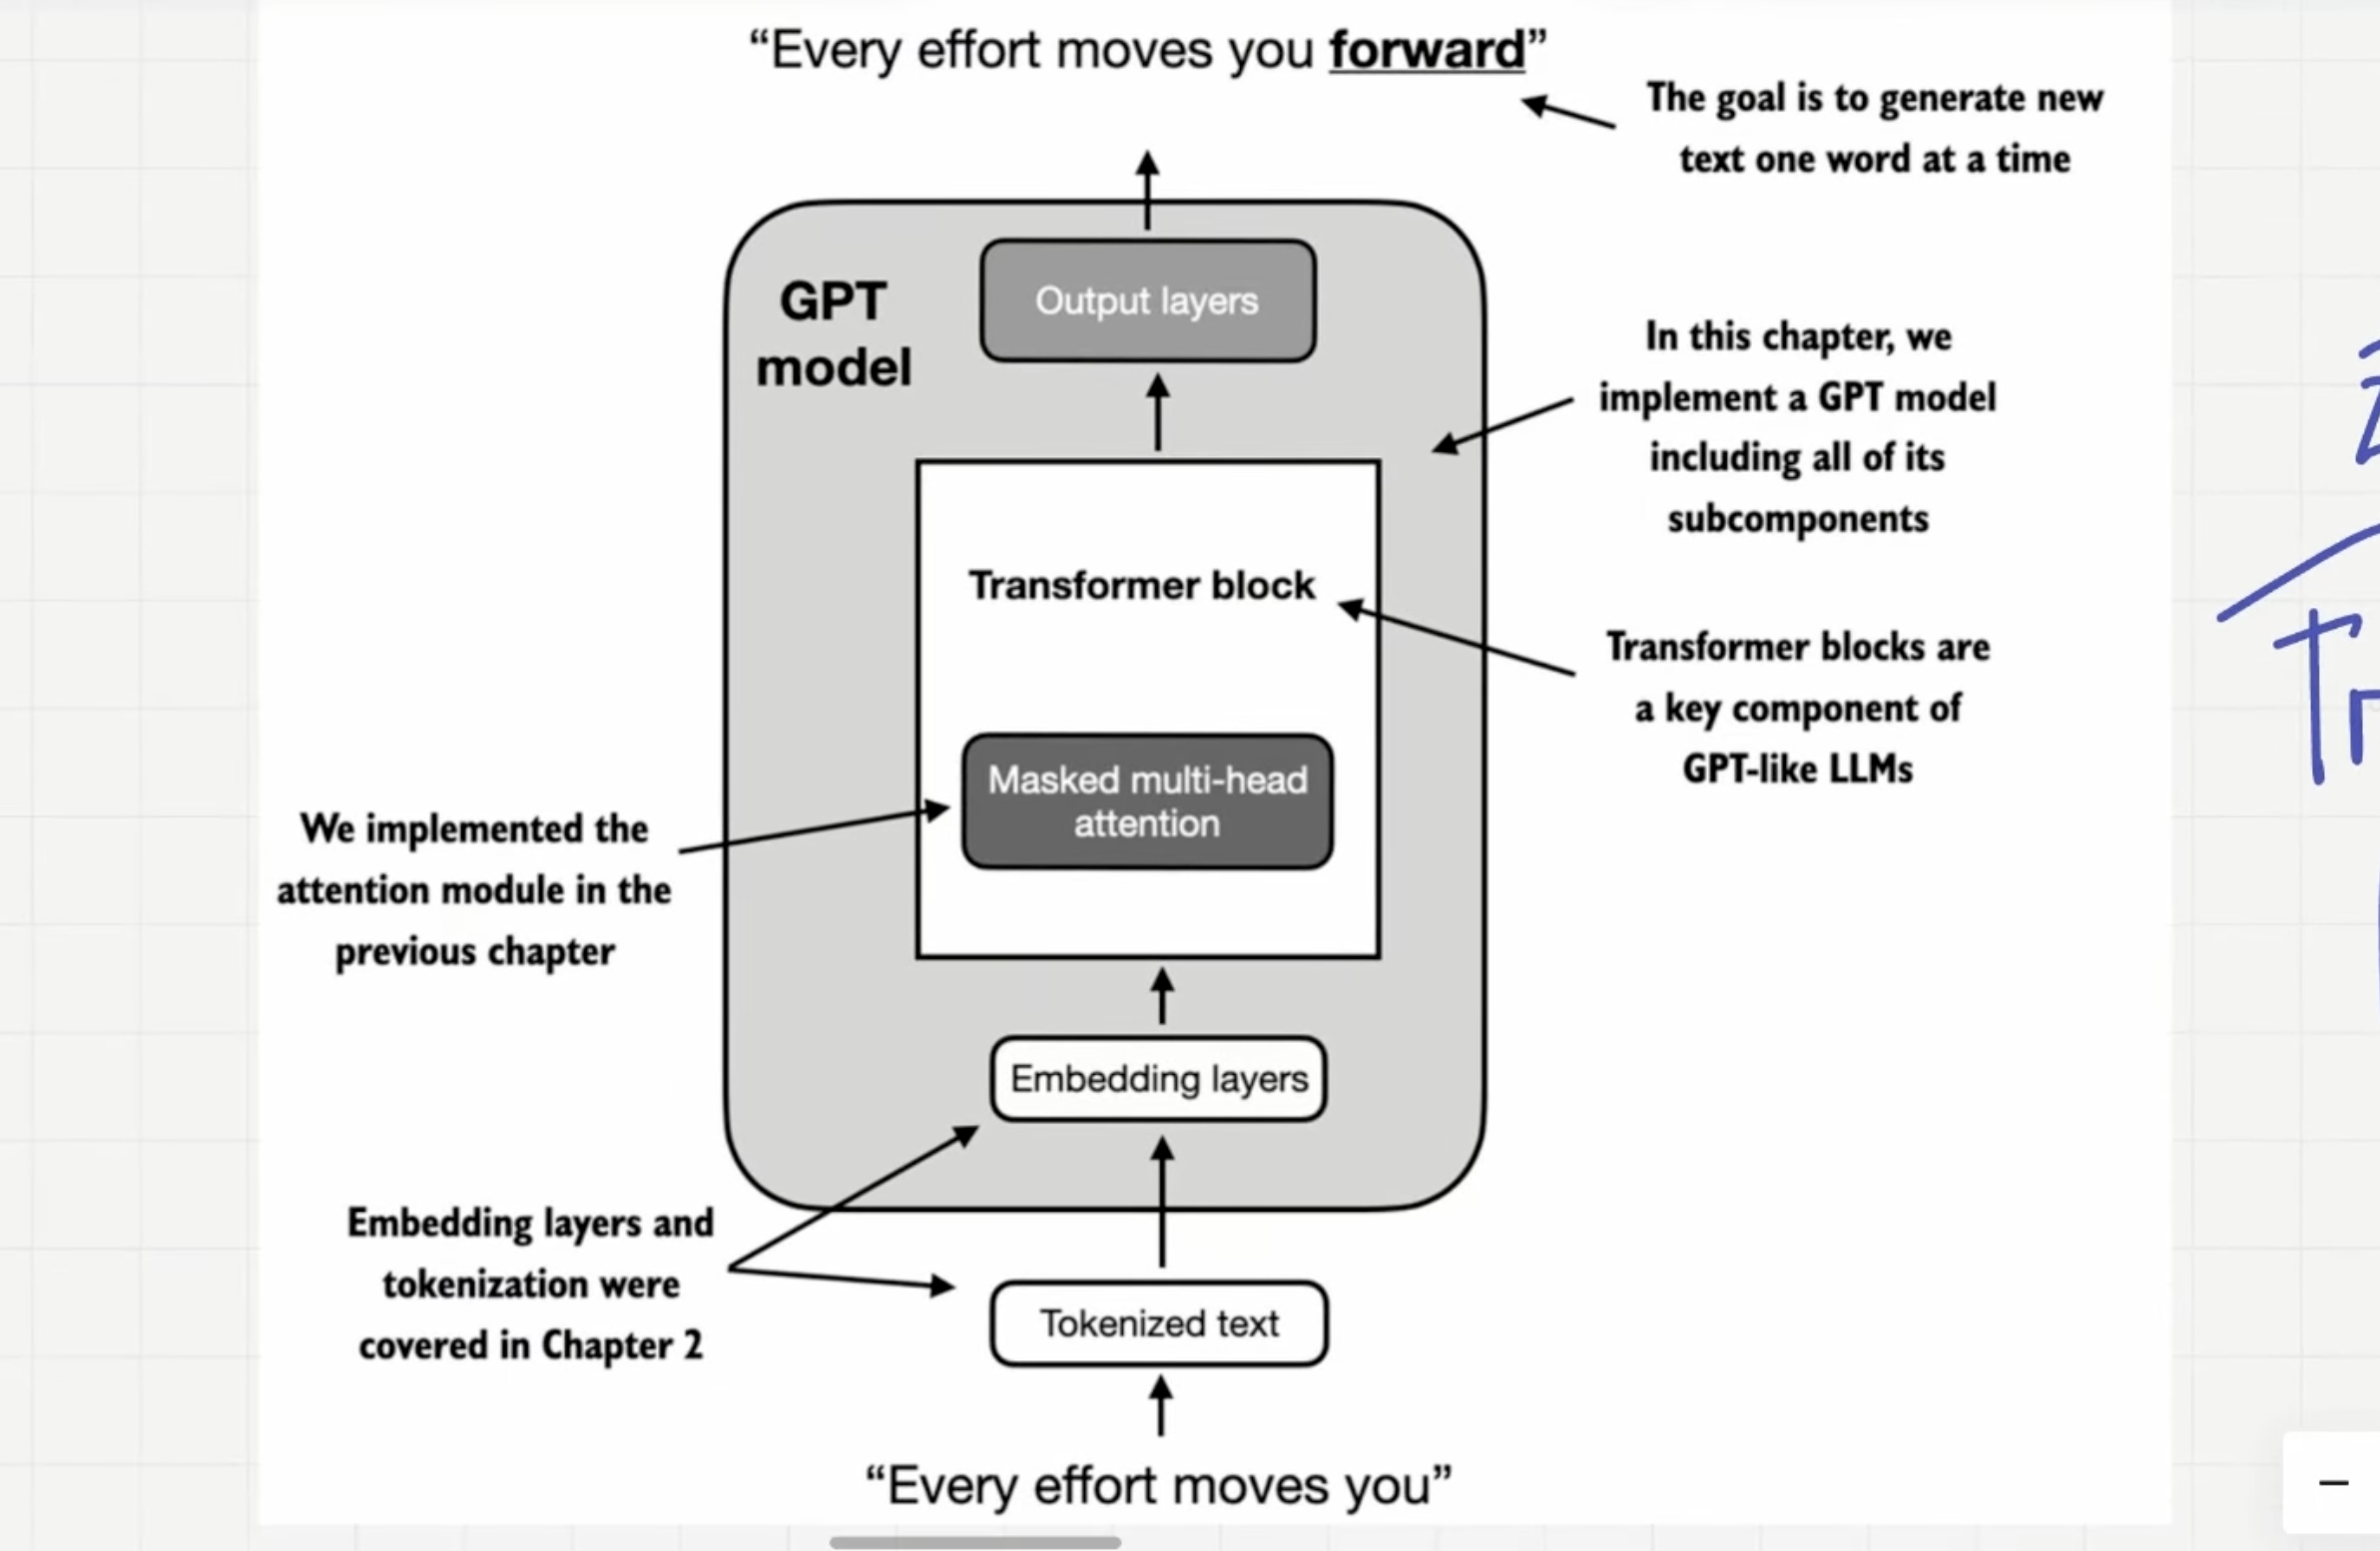



</p>
</div>




In [1]:
# Lets define the confoguration for GPT Model
# We planning to build the GPT Model with 124M parameters. This is the small GPT version

GPT_CONFIG_124M = {
  "vocab_size"     : 50257, # BPE encoding has the vocab size of 50257
  "context_length" : 1024,  # number of token we can look at ones to predict new word
  "emb_dim"        : 768,   # The Toekn Embedding dimension
  "n_heads"        : 12,    # number of attention heads
  "n_layers"       : 12,    # Number of layers (Transformer blocks)
  "drop_rate"      : 0.1,   # Dropout Rate
  "qkv_bias"       : False  # Quert-Key-Value Bias
}

### GPT ARCHITECTURE : Dummy GPT MODEL CLASS

In [2]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"] , cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"] , cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])

        # this is the layer to convert the vector output to Logits vector 
        # of size batch * Context length * vocab_size
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size , seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx) # Embedd the tokesn to higher dimensional space
        pos_embeds = self.pos_emb(torch.arange(seq_len,device=in_idx.device)) # get Pos Embedding
        x=tok_embeds + pos_embeds # Combine the Token Embeds with its position embeds
        x=self.drop_emb(x)   # Perform Droput 
        x=self.trf_blocks(x)
        x= self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [3]:
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


In [4]:
class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

---

# Part 4 : Shortcut connections

# `IMPLEMEMNTING Short cut connections`

<div class="alert alert-block alert-info">
<b>Norm Layer </b> 
<p>   

As seen in the image below (the detailed transformation block), we will not code and implement the NormLayer1 component in the transformer block

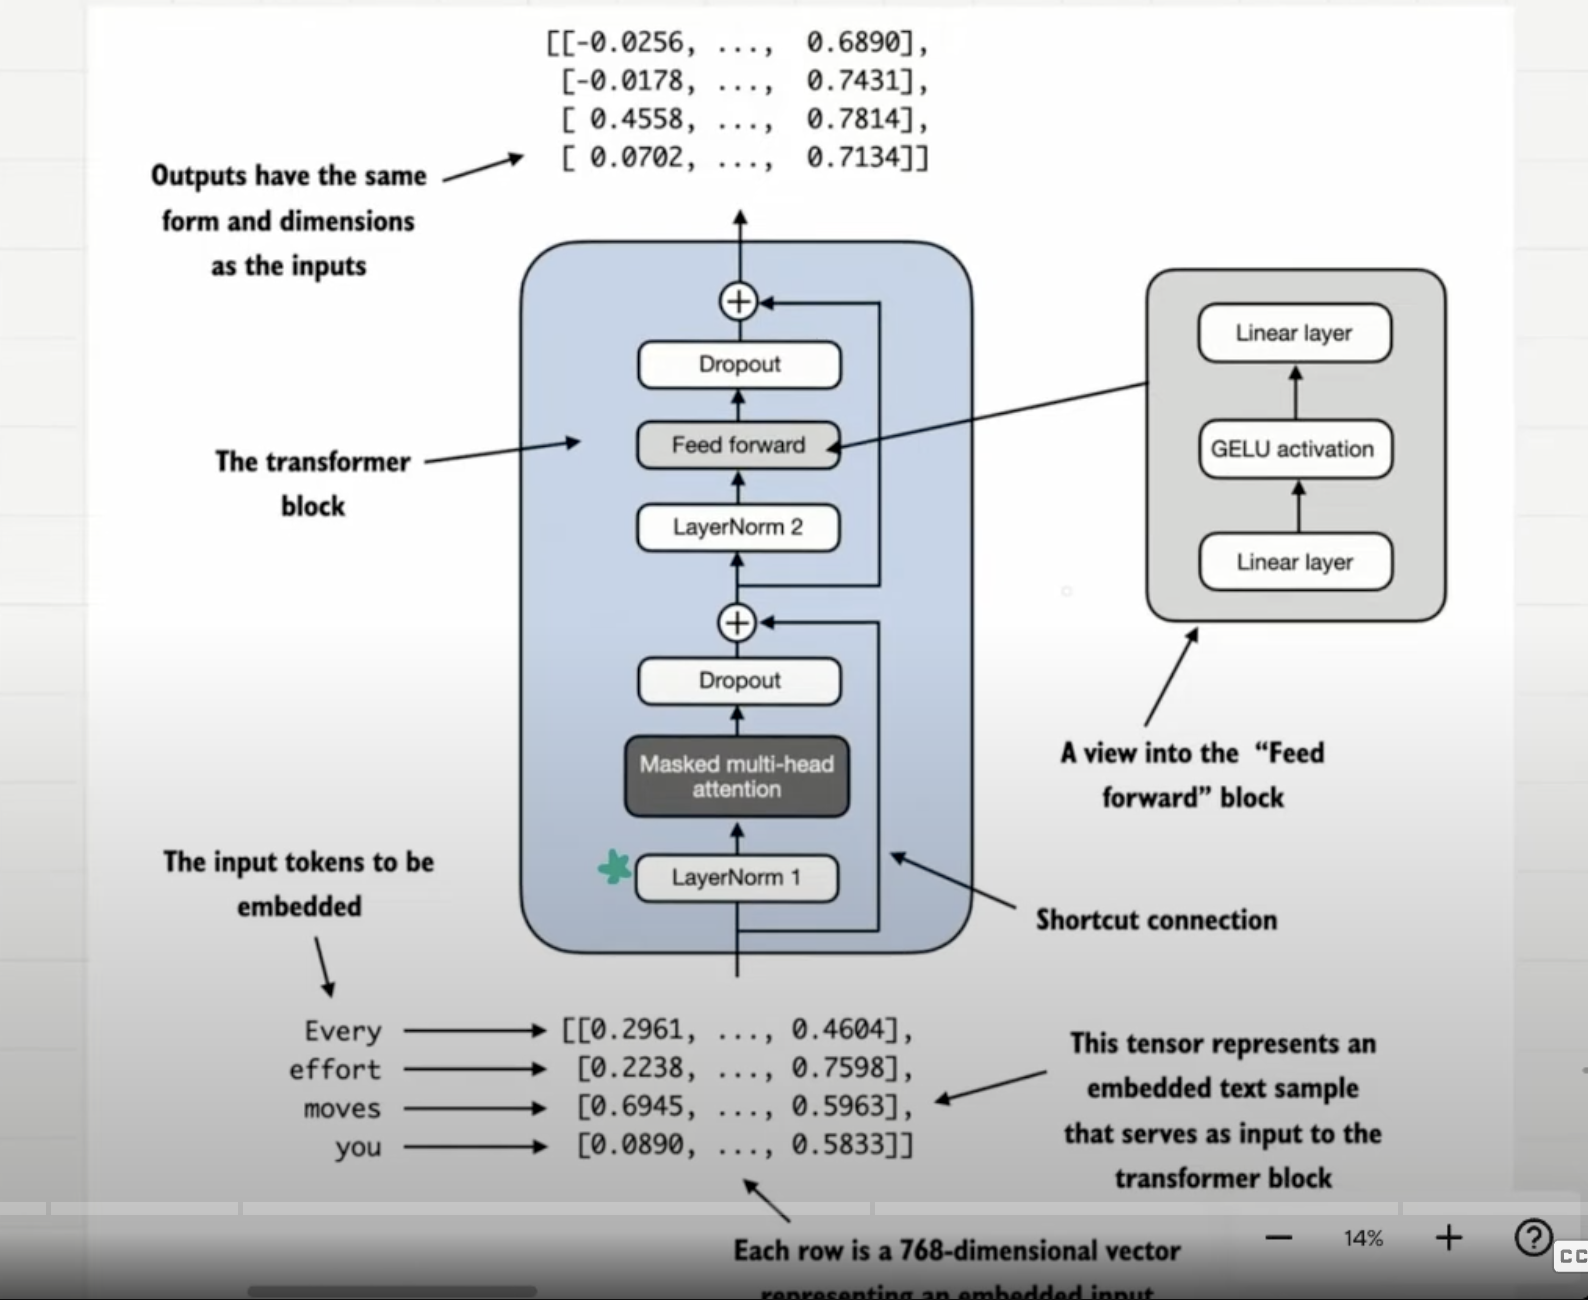

</p>
</div>



---

<div class="alert alert-block alert-info">
<b>Short cut connections</b> 
<p>   

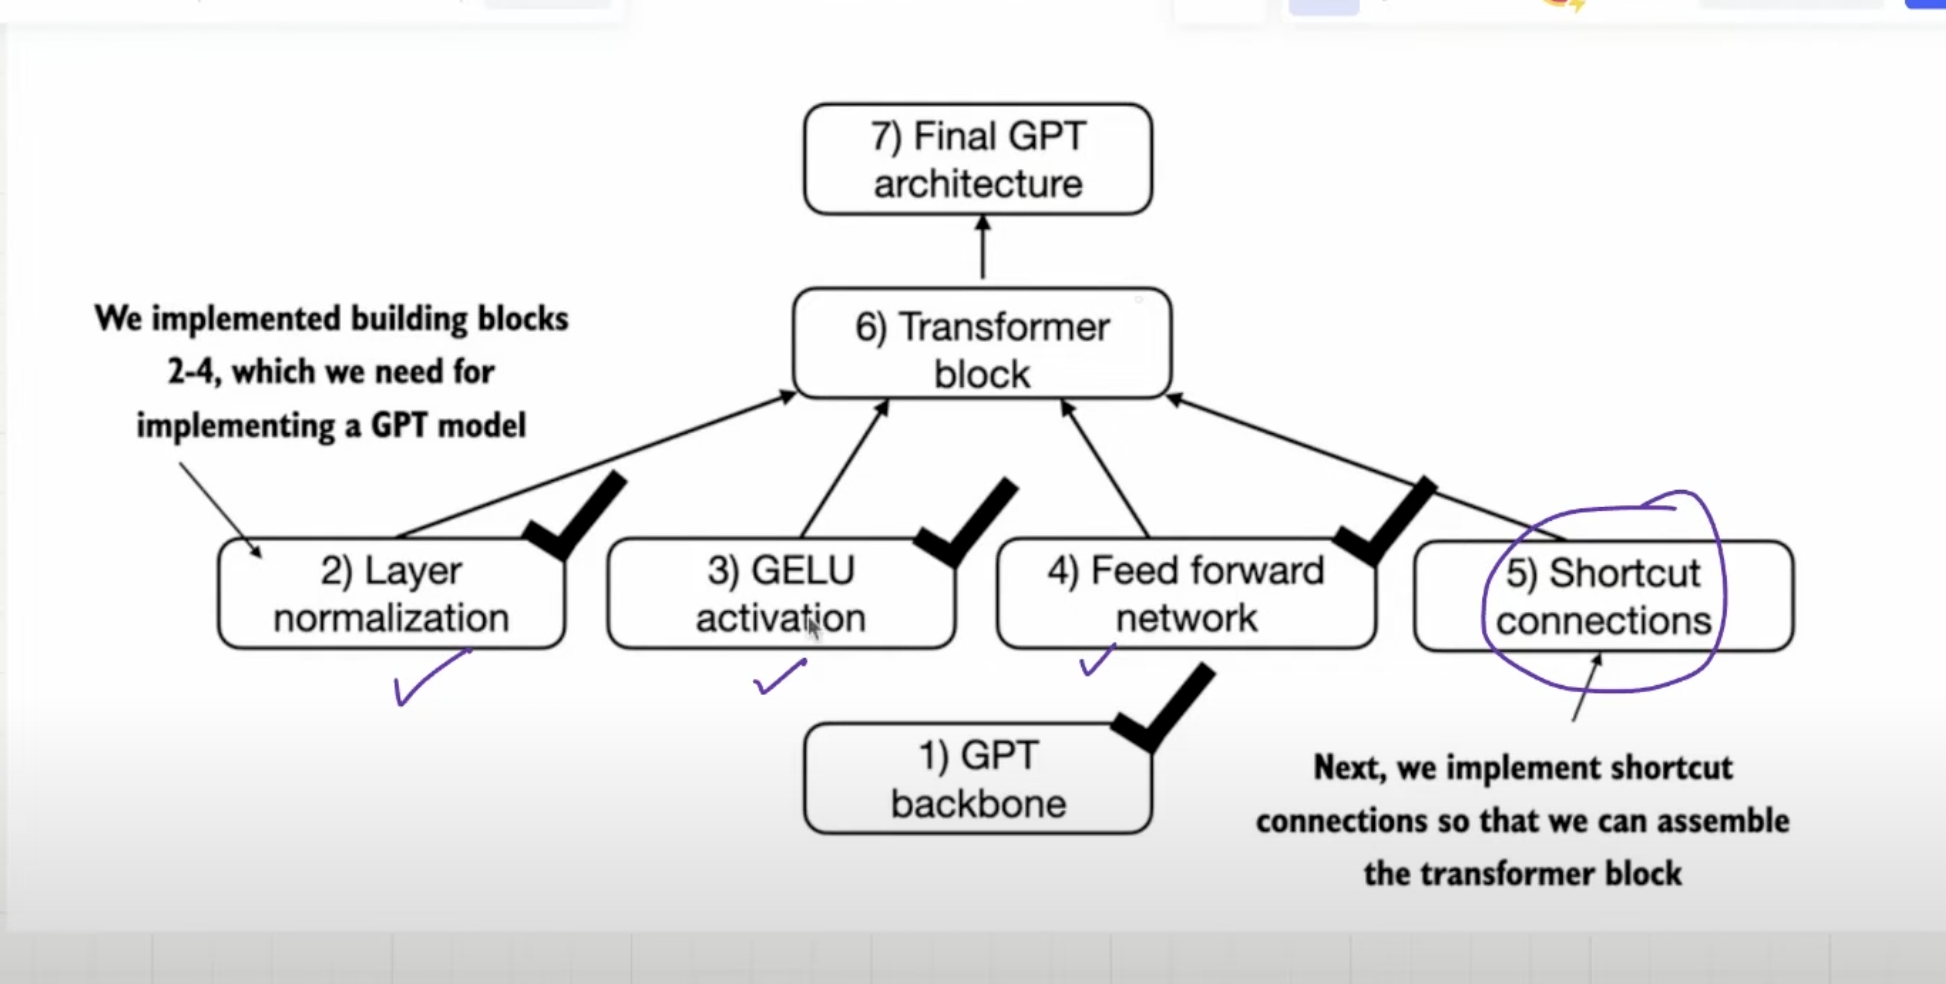
</p>

</div>

---

<div class="alert alert-block alert-info">
<b>Why Implement Short connection  </b> 
<p>   
This is also called as Skipped connection or Residual Network

This is important to tackle the problem of vanishing gradient.

I back propogation , we calculate the gradient and then update the weights . By the time it reached the first layer , the gradient gets smaller and smaller (close to zero) that makes the learning stagnent.

The network is not able to analyze and build the pattern , as the weights are so small that they do not reflect any changes.

Hence , in this case what we do is add the previous layer output to the current level , so gradient is still in effect and netork keeps learning

Lets see at bekow figure the effect of shortcut connections

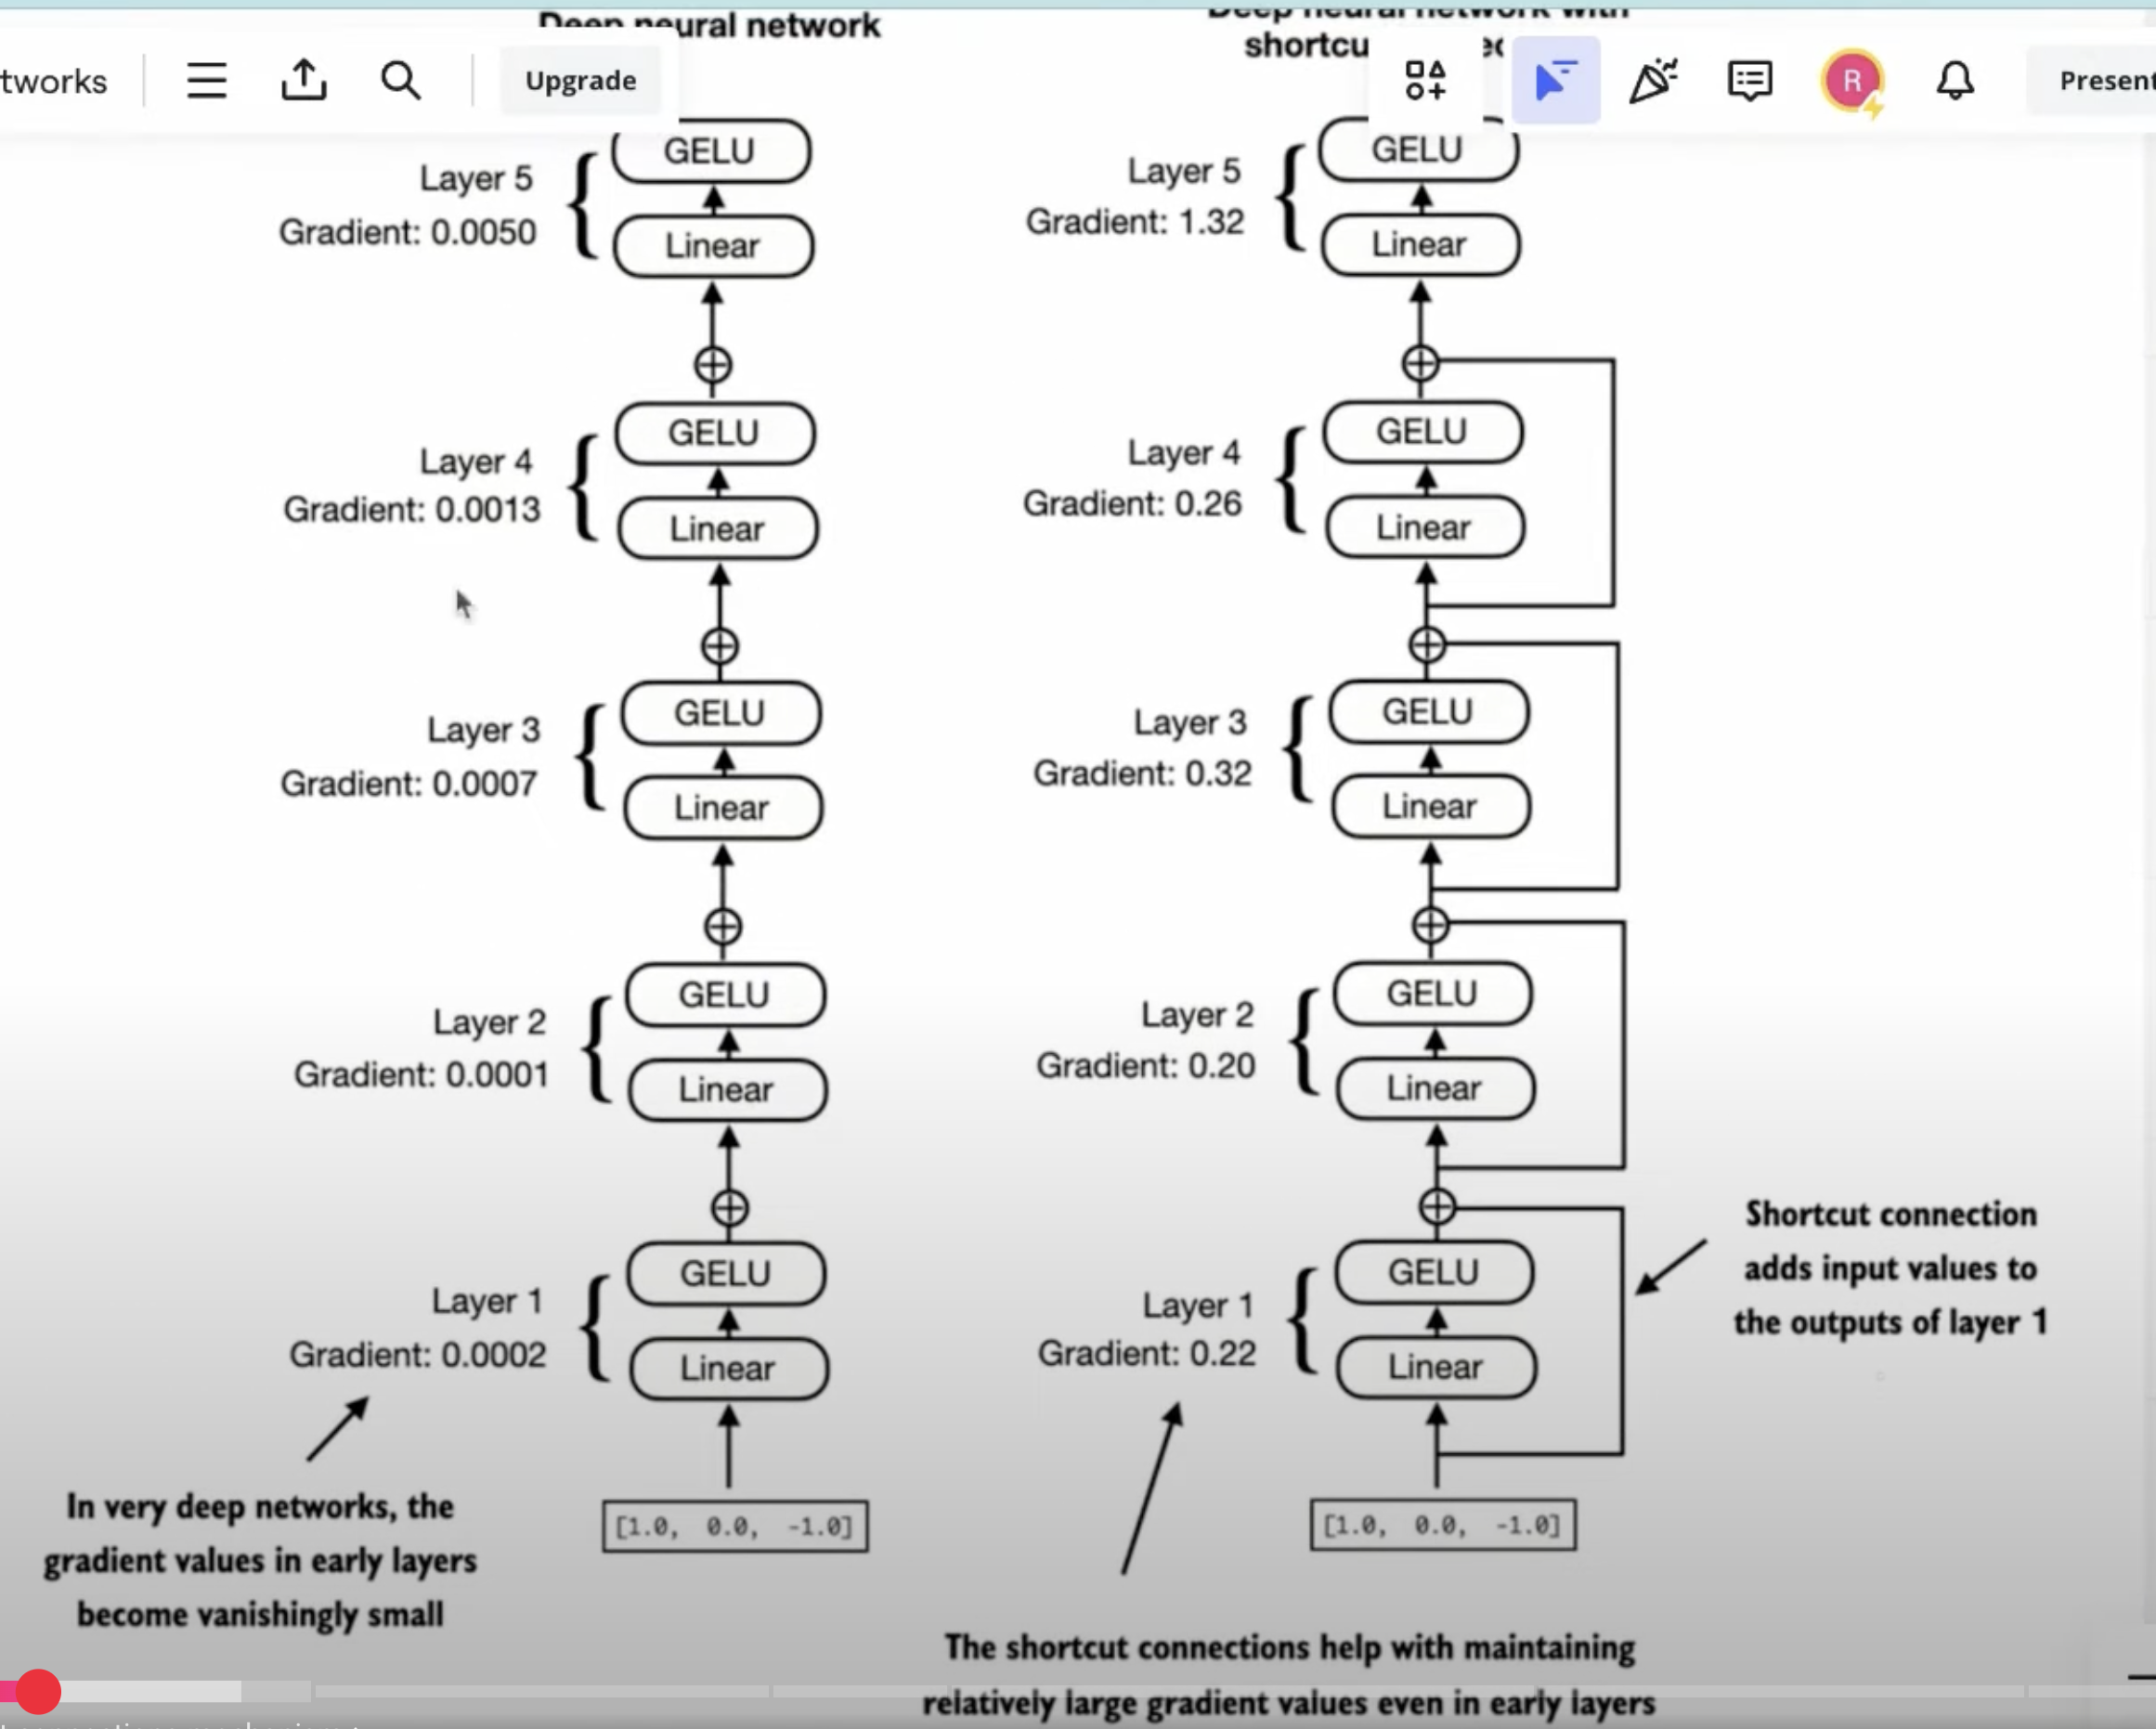

As we can the Deep neural Network without shortcut connection (Left) has the Gradient reduced to zero. This make the neural network stagent 

As inversion to the Deep Nueral network with shortcut connections (Right) the Gradient has much larger values , that makes the network keep learning

</p>
</div>

<div class="alert alert-block alert-info">
<b>Lets Implement the Skip connection/Shortcut connections </b> 
<p>   

How Neural Network will look like below.

1. Without shortcut connections (top)
2. With shortcurt connections (bottom)

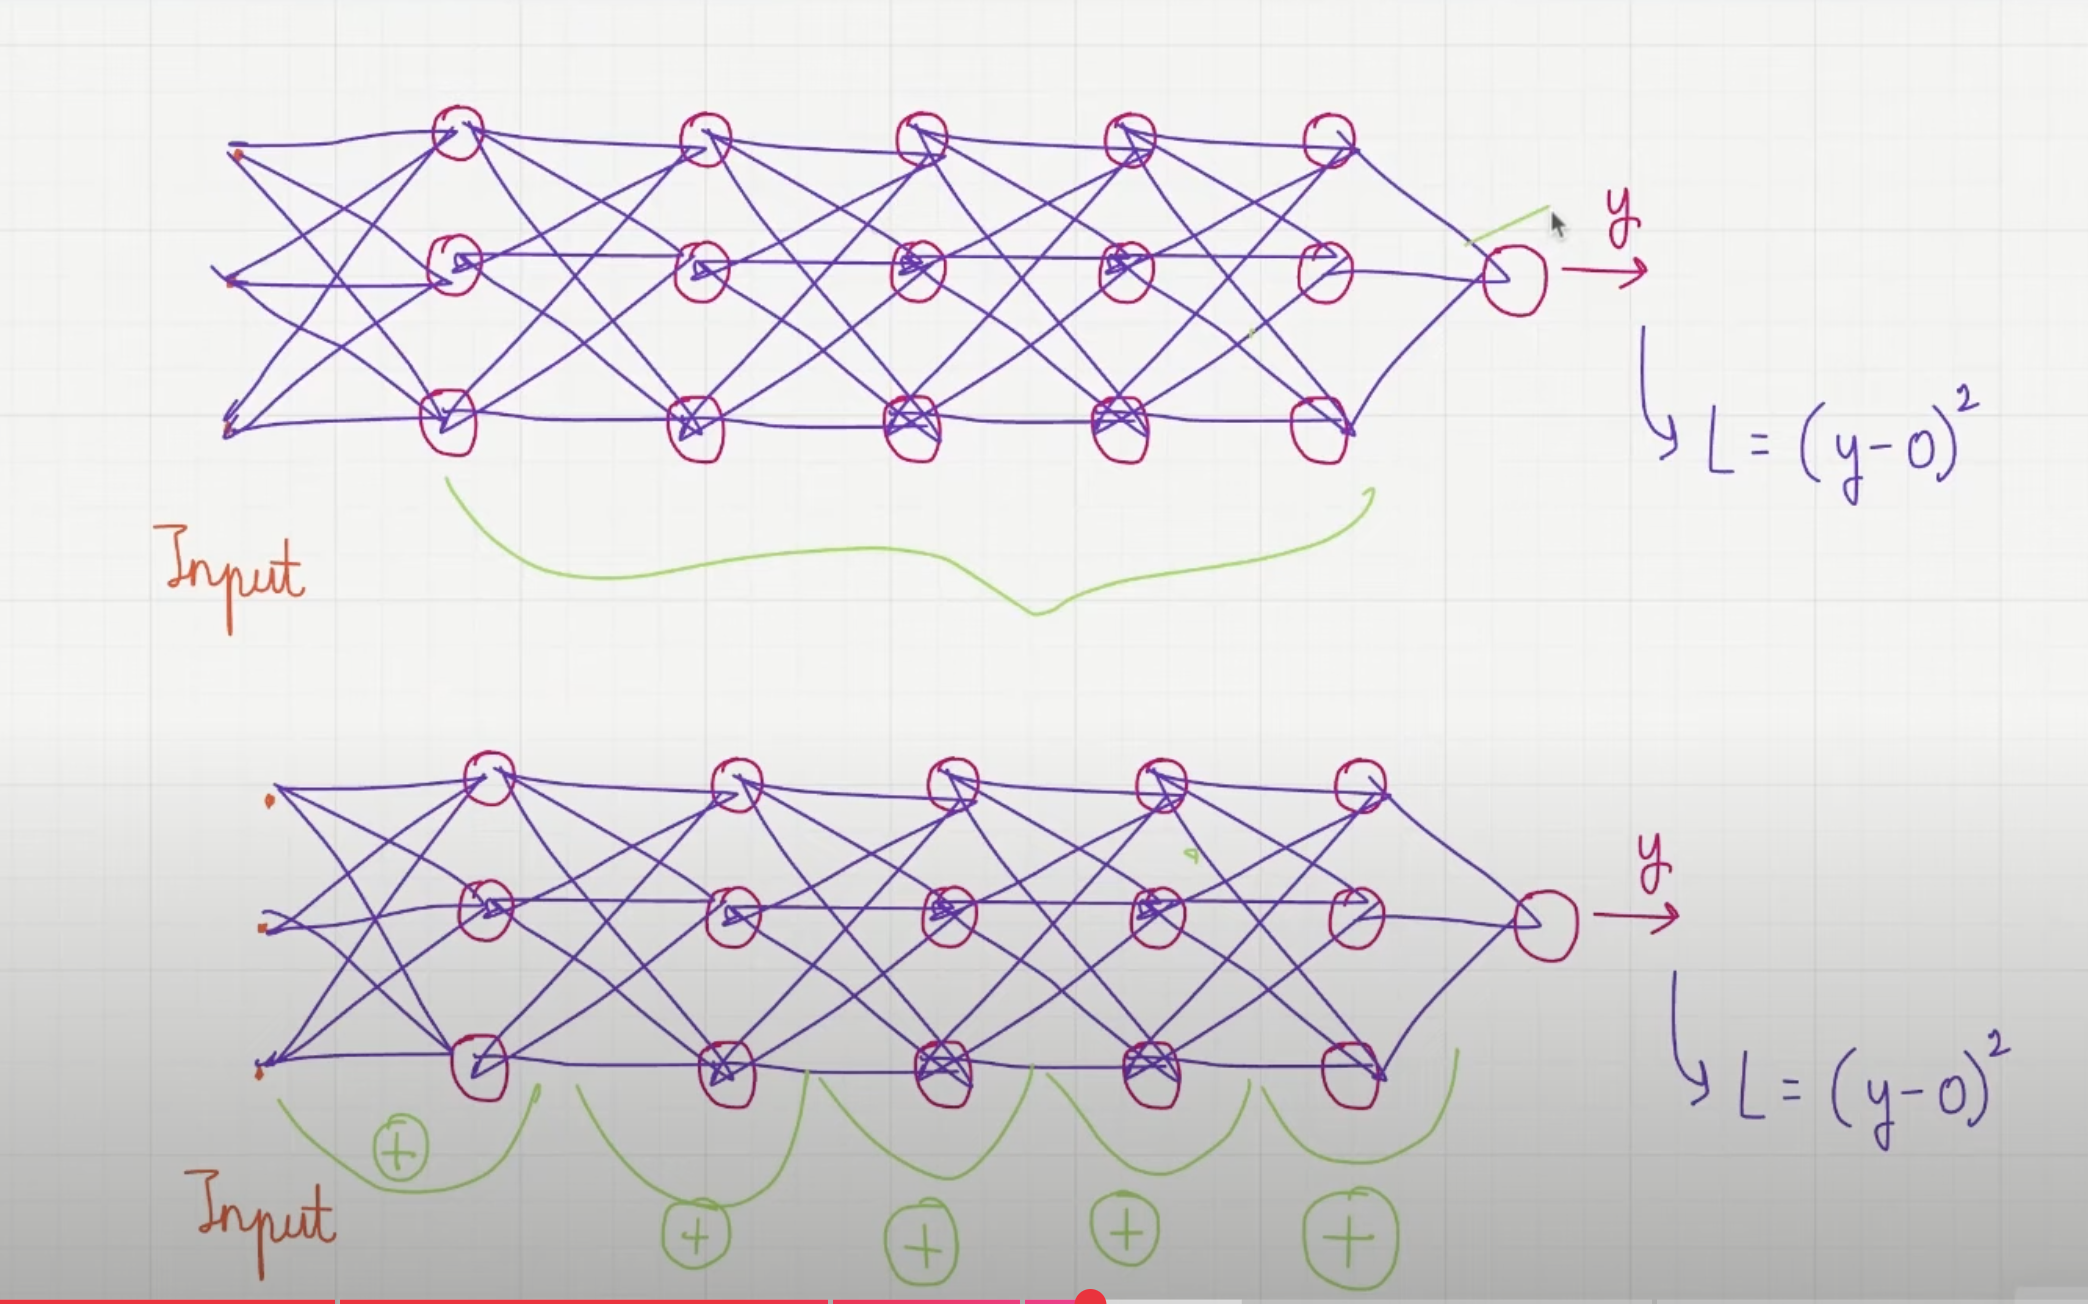

</p>
</div>

In [2]:
import torch
import torch.nn as nn

In [5]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x):
        activation = 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x,3))
        ))

        return activation

In [53]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes , use_shortcut):
        super().__init__()
        self.use_shortcut=use_shortcut
        self.layers = nn.ModuleList([
              nn.Sequential(nn.Linear(layer_sizes[0] , layer_sizes[1]),GELU()),
              nn.Sequential(nn.Linear(layer_sizes[1] , layer_sizes[2]),GELU()),
              nn.Sequential(nn.Linear(layer_sizes[2] , layer_sizes[3]),GELU()),
              nn.Sequential(nn.Linear(layer_sizes[3] , layer_sizes[4]),GELU()),
              nn.Sequential(nn.Linear(layer_sizes[4] , layer_sizes[5]),GELU()), # Layer 5th us output layer with one neuron
        ])

    def forward(self,x):

        # Loop through each layer  , to collect the output of each layer
        for layer in self.layers:
            layer_output = layer(x)

            # Check if shortcut is set to True ot False , and ensure it is not the last layer
            if self.use_shortcut and x.shape == layer_output.shape:
                # add the previous layer output to the ciurrent layer output
                x = x + layer_output

            # just carry on 
            else:
                x = layer_output

        return x
            

<div class="alert alert-block alert-info">
<b>Initiate The above Neural Network without shortcur connections </b> 
<p>   
Basically by setting the flag use_shortcut=False

</p>
</div>

In [54]:
layer_sizes = [3,3,3,3,3,1]
sample_input = torch.tensor([1.0, 0.0, -1.0])
torch.manual_seed(123)

model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes,use_shortcut=False)

In [61]:
def print_gradients(model ,x):
    output = model(x)
    target = torch.tensor([0.0])

    loss = nn.MSELoss()
    #loss = nn.CrossEntropyLoss()
    loss = loss(output , target)

    loss.backward()

    for name , param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has the gradient mean of {param.grad.abs().mean().item()}")

In [62]:
print_gradients(model_without_shortcut , sample_input)

layers.0.0.weight has the gradient mean of 0.002903276588767767
layers.1.0.weight has the gradient mean of 0.0017285828944295645
layers.2.0.weight has the gradient mean of 0.010292839258909225
layers.3.0.weight has the gradient mean of 0.020131848752498627
layers.4.0.weight has the gradient mean of 0.07267183810472488


<div class="alert alert-block alert-info">
As we can see based on the output of the print_gradients function, the gradients become
smaller as we progress from the last layer (layers.4) to the first layer (layers.0), which
is a phenomenon called the vanishing gradient problem.
    
</div>

<div class="alert alert-block alert-info">
<b> Lets see the same with shortcut connections enabled </b>
    
</div>

In [65]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes,use_shortcut=True)
print_gradients(model_with_shortcut , sample_input)

layers.0.0.weight has the gradient mean of 0.22169791162014008
layers.1.0.weight has the gradient mean of 0.20694106817245483
layers.2.0.weight has the gradient mean of 0.32896995544433594
layers.3.0.weight has the gradient mean of 0.2665732204914093
layers.4.0.weight has the gradient mean of 1.3258540630340576


<div class="alert alert-block alert-info">
As we can see, based on the output, the last layer (layers.4) still has a larger gradient
than the other layers. 

However, the gradient value stabilizes as we progress towards the
first layer (layers.0) and doesn't shrink to a vanishingly small value.
</div>

<div class="alert alert-block alert-warning">

In conclusion, shortcut connections are important for overcoming the limitations posed
by the vanishing gradient problem in deep neural networks. 

Shortcut connections are a core building block of very large models such as LLMs, and they will help facilitate more effective
training by ensuring consistent gradient flow across layers when we train the GPT model 
</div>